# Using Autoencoders + KMeans for Marketing segmentation

Marketing is crucial for the growth and sustainability of any business. What really matters to customers is to know their customers. This kind of knowledge means the possibility to perform what is called <em>market segmentation</em>.
<br><br>
Our use case is a New York City Bank that had the opportunity to study their customers for the past 6 months and now want to lanunch a targeted marketing campaign by dividing them into at least 3 groups.
<br><br>
After taking a look at the data, with a really minimum preprocessing, they are actually clean, we will follow two approaches to perform a segmentation. 
<br><br>
First, we'll use <em>Kmeans Clustering</em>, an algorithm that assign data to K different clusters. It is an <em>unsupervised algorithm</em>, 'cause we don't need labels to train our model. We just need a number K, meaning how many clusters we will be splitting our data in, and in order to find a good value for it, we are gonna use a method called <em>Elbow Method</em>. We will eventually show how data behave in different clusters and finally reduce dimensions of data to 2 using <em>Principal Component Analysis</em> to visually see where different clusters are located. 
<br><br>
Second and last, we'll repeat this approach, but this time we'll reduce the dimension of our data from 17 features to 10 using <em>Autoencoders</em>, a particular Neural Network model specialized in what is called <em>representation</em> learning. After this, everything will proceed the same as before, but now, with this extra reduction, the number of clusters is gonna be 4 and our data will be segmented by this number.


## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Load and Check Dataset

In [2]:
data = pd.read_csv('Marketing_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [3]:
data.describe()

# Mean balance is $1564 
# Balance frequency is frequently updated on average ~0.9
# Purchases average is $1000
# one off purchase average is ~$600
# Average purchases frequency is around 0.5
# average ONEOFF_PURCHASES_FREQUENCY, PURCHASES_INSTALLMENTS_FREQUENCY, and CASH_ADVANCE_FREQUENCY are generally low
# Average credit limit ~ 4500
# Percent of full payment is 15%
# Average tenure is 11 years

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


In [4]:
# Let's see who made one off purchase of $40761!

data[data['ONEOFF_PURCHASES']==data['ONEOFF_PURCHASES'].max()]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
550,C10574,11547.52001,1.0,49039.57,40761.25,8278.32,558.166886,1.0,1.0,0.916667,0.083333,1,101,22500.0,46930.59824,2974.069421,0.25,12


In [5]:
# Another customer I want to check is the one who has more than 47k$ of cash advance!
# This customer made 123 cash advance transactions!!
# Never paid credit card in full

data[data['CASH_ADVANCE']==data['CASH_ADVANCE'].max()]

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
2159,C12226,10905.05381,1.0,431.93,133.5,298.43,47137.21176,0.583333,0.25,0.5,1.0,123,21,19600.0,39048.59762,5394.173671,0.0,12


In [6]:
# finally, let's see the head of the dataset

data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [7]:
# CUSTID: Identification of Credit Card holder 
# BALANCE: Balance amount left in customer's account to make purchases
# BALANCE_FREQUENCY: How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
# PURCHASES: Amount of purchases made from account
# ONEOFFPURCHASES: Maximum purchase amount done in one-go
# INSTALLMENTS_PURCHASES: Amount of purchase done in installment
# CASH_ADVANCE: Cash in advance given by the user
# PURCHASES_FREQUENCY: How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
# ONEOFF_PURCHASES_FREQUENCY: How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
# PURCHASES_INSTALLMENTS_FREQUENCY: How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
# CASH_ADVANCE_FREQUENCY: How frequently the cash in advance being paid
# CASH_ADVANCE_TRX: Number of Transactions made with "Cash in Advance"
# PURCHASES_TRX: Number of purchase transactions made
# CREDIT_LIMIT: Limit of Credit Card for user
# PAYMENTS: Amount of Payment done by user
# MINIMUM_PAYMENTS: Minimum amount of payments made by user  
# PRC_FULL_PAYMENT: Percent of full payment paid by user
# TENURE: Tenure of credit card service for user

## Explore Dataset

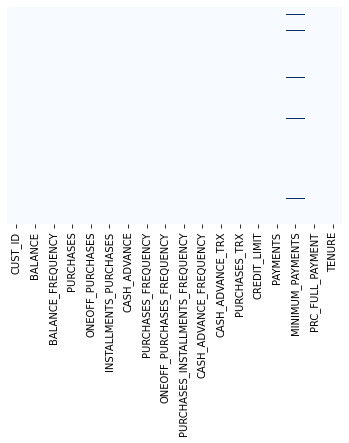

In [8]:
# Let's see if we have any missing data\

sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='Blues');

In [9]:
# If we want to see the numbers

data.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [10]:
# Fill up the missing elements with mean of the 'MINIMUM_PAYMENT' 
# Then check again

data['MINIMUM_PAYMENTS'].fillna(data['MINIMUM_PAYMENTS'].mean(), inplace=True)
data.isnull().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        1
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

In [11]:
# Let's do the same with the missing element in 'CREDIT_LIMIT'

data['CREDIT_LIMIT'].fillna(data['CREDIT_LIMIT'].mean(), inplace=True)
data.isnull().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

In [12]:
# Check if there are duplicated rows, there aren't

data.duplicated().sum()

0

In [13]:
# Let's drop Customer ID since it has no meaning here 

data.drop('CUST_ID', axis=1, inplace=True)
data.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


/Users/maurizioscibilia/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


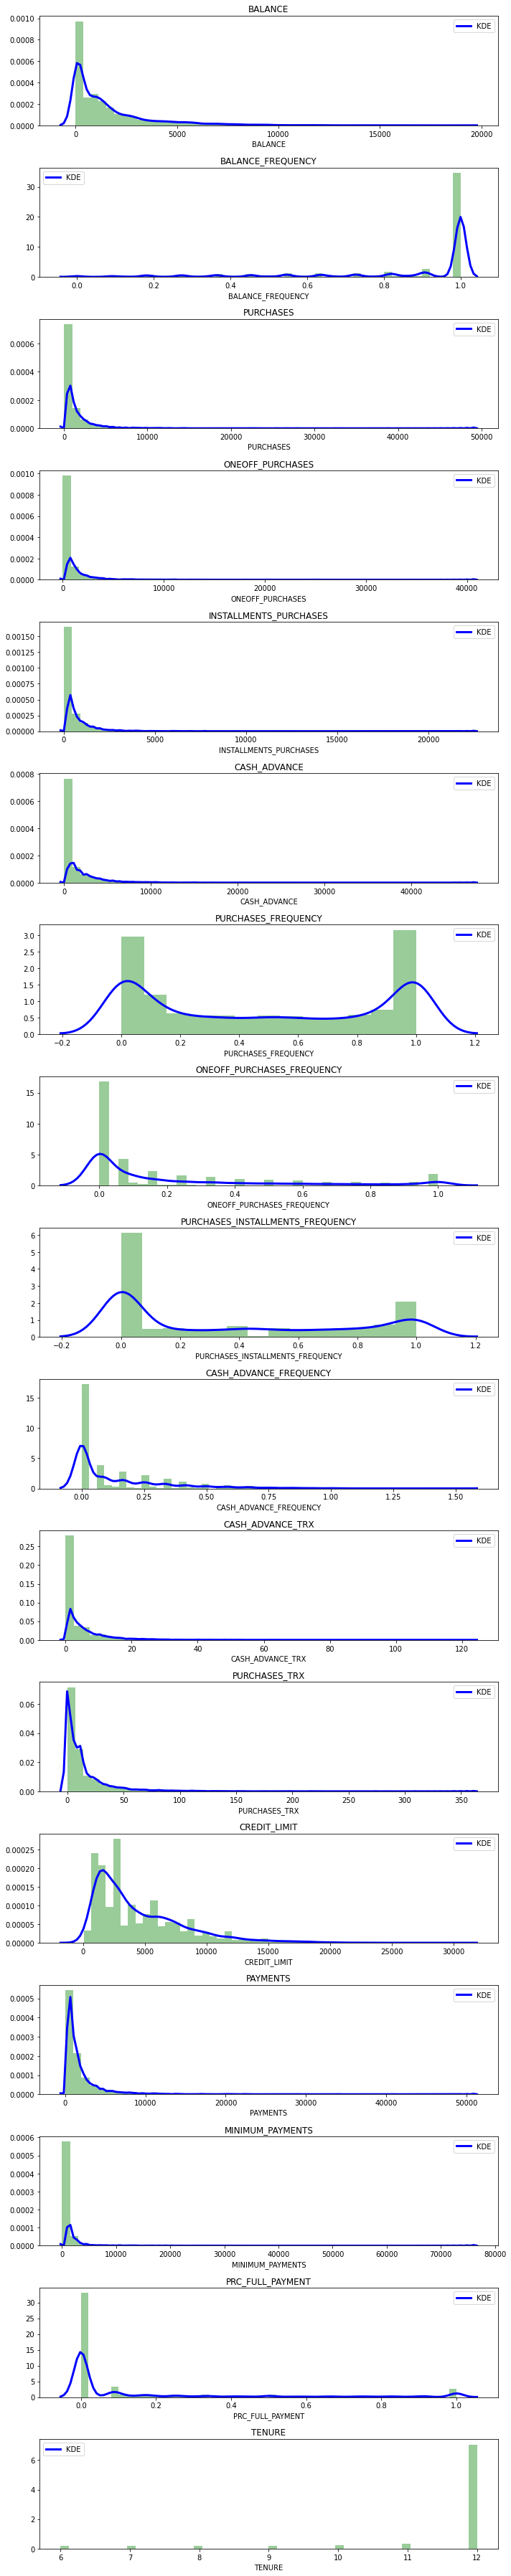

In [14]:
# distplot combines the matplotlib.hist function with seaborn kdeplot()

plt.figure(figsize=(10,50))
for i in range(data.shape[1]):
    plt.subplot(data.shape[1], 1, i+1)
    sns.distplot(data[data.columns[i]], 
                 kde_kws={'color':'b', 'lw':3, 'label':'KDE'}, 
                 hist_kws={'color':'g'})
    plt.title(data.columns[i])
plt.tight_layout()

So, the BALANCE_FREQUENCY, showing how frequently tha balance is udated, tells us that our customers tend to use the credit card a lot. PURCHASES_FREQUENCY is bimodal, meaning there are two relative majorities, one of people using the card rarely and one of people using the card very much. Something else: cash advance is mostly not used, which is good, considering the price for this service; almost no one pays in full; the great part of the customers have a tenure higher than 10 years. 

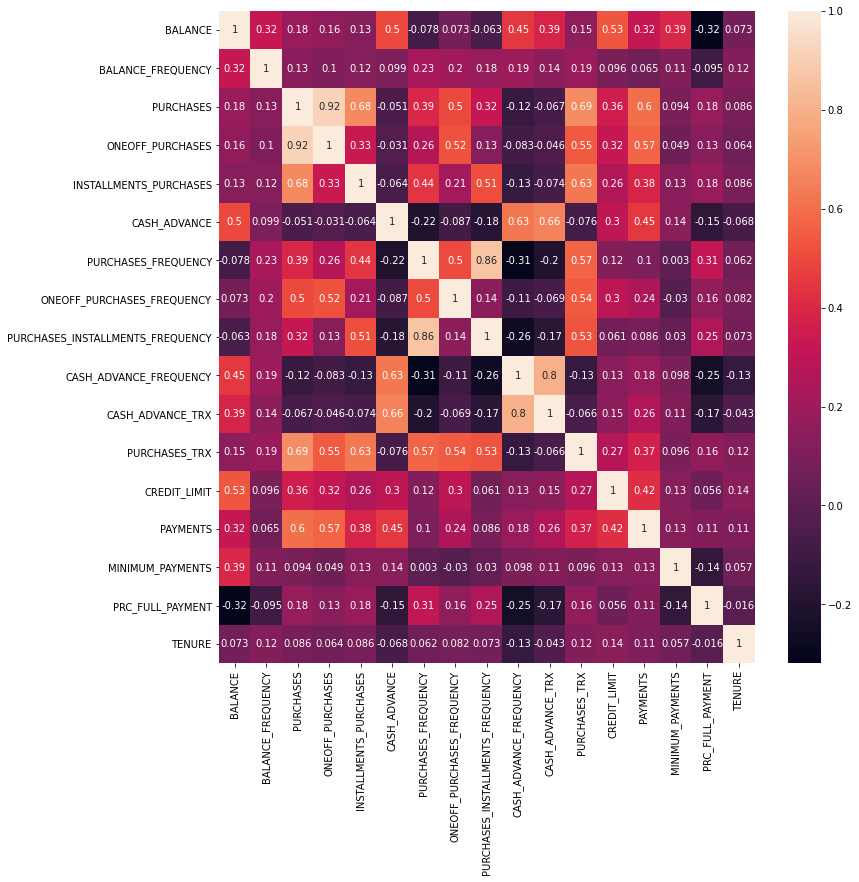

In [15]:
# Let's check the correlation between the different columns of our dataset

_, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(data.corr(), annot=True, ax=ax);

PURCHASES have high correlation between one-off purchases, installment purchases, purchase transactions, credit limit and payments. Strong Positive Correlation between PURCHASES_FREQUENCY and PURCHASES_INSTALLMENT_FREQUENCY

## K-Means Clustering

### Finding the optimal K though the 'Elbow' method

In [16]:
# first, let's scale our data

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [17]:
data_scaled

array([[-0.73198937, -0.24943448, -0.42489974, ..., -0.31096755,
        -0.52555097,  0.36067954],
       [ 0.78696085,  0.13432467, -0.46955188, ...,  0.08931021,
         0.2342269 ,  0.36067954],
       [ 0.44713513,  0.51808382, -0.10766823, ..., -0.10166318,
        -0.52555097,  0.36067954],
       ...,
       [-0.7403981 , -0.18547673, -0.40196519, ..., -0.33546549,
         0.32919999, -4.12276757],
       [-0.74517423, -0.18547673, -0.46955188, ..., -0.34690648,
         0.32919999, -4.12276757],
       [-0.57257511, -0.88903307,  0.04214581, ..., -0.33294642,
        -0.52555097, -4.12276757]])

In [18]:
scores = []
range_values = range(1,20)
for i in range_values:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data_scaled)
    scores.append(kmeans.inertia_)

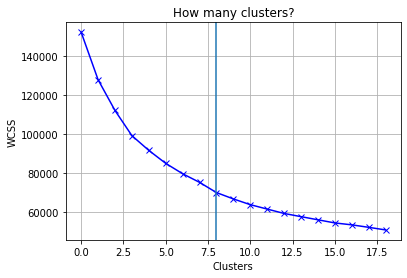

In [19]:
# checking our scores

plt.plot(scores, 'bx-')
plt.axvline(x=8)
plt.title('How many clusters?')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show();

# A proper number of clusters could be 8!

### Apply K-Means

In [20]:
kmeans = KMeans(8)
kmeans.fit(data_scaled)
labels = kmeans.labels_
labels

array([7, 6, 1, ..., 5, 5, 5], dtype=int32)

In [21]:
# concatenate the clusters labels to our original dataframe

data_cluster = pd.concat([data, pd.DataFrame({'cluster':labels})], axis=1)
data_cluster.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,7
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,6
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,1
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,7
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,7


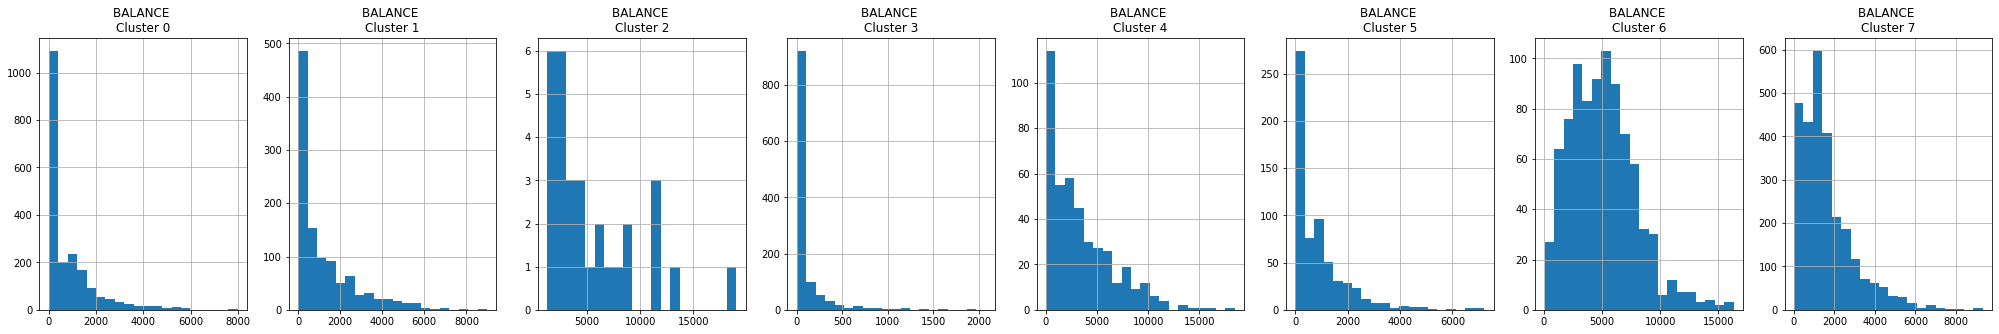

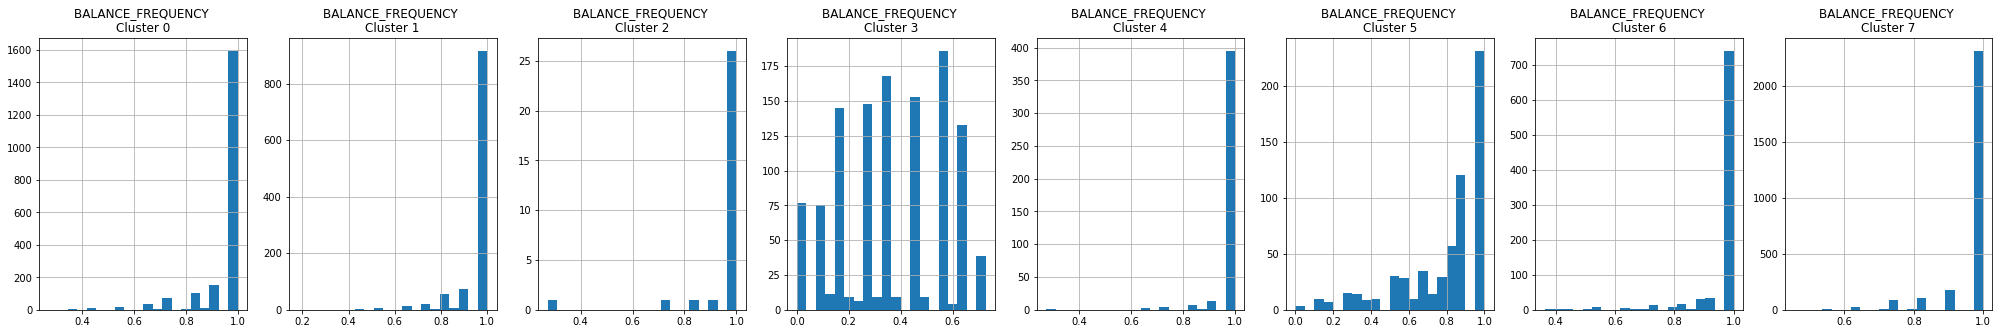

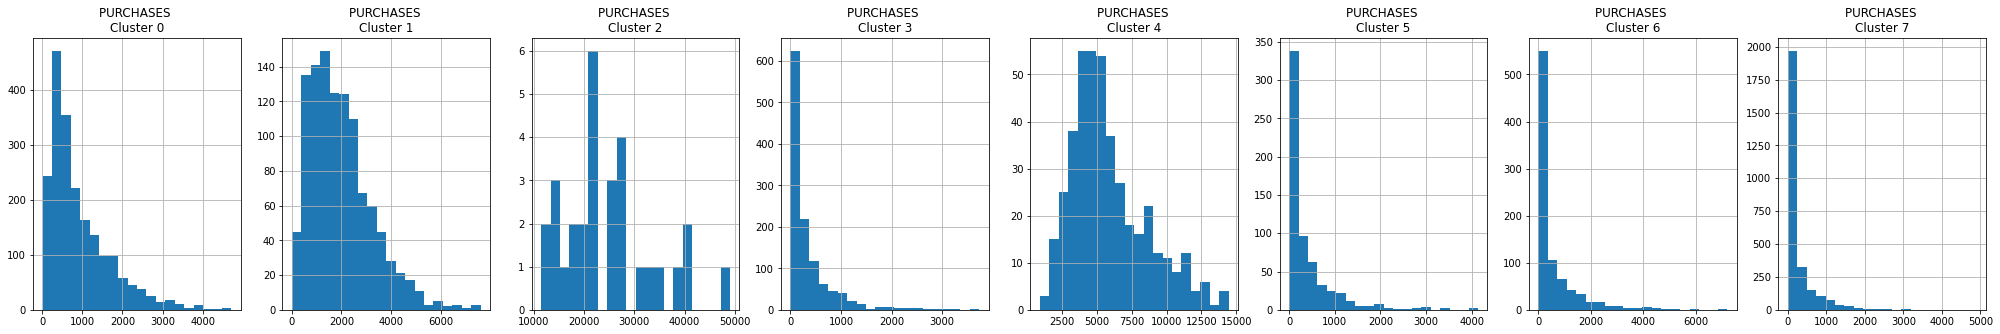

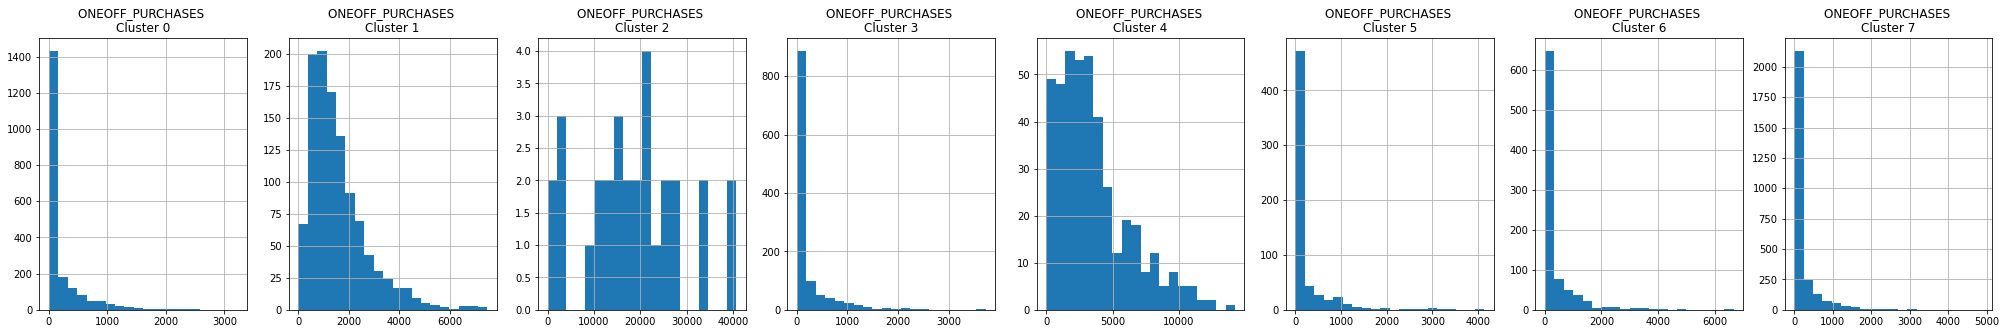

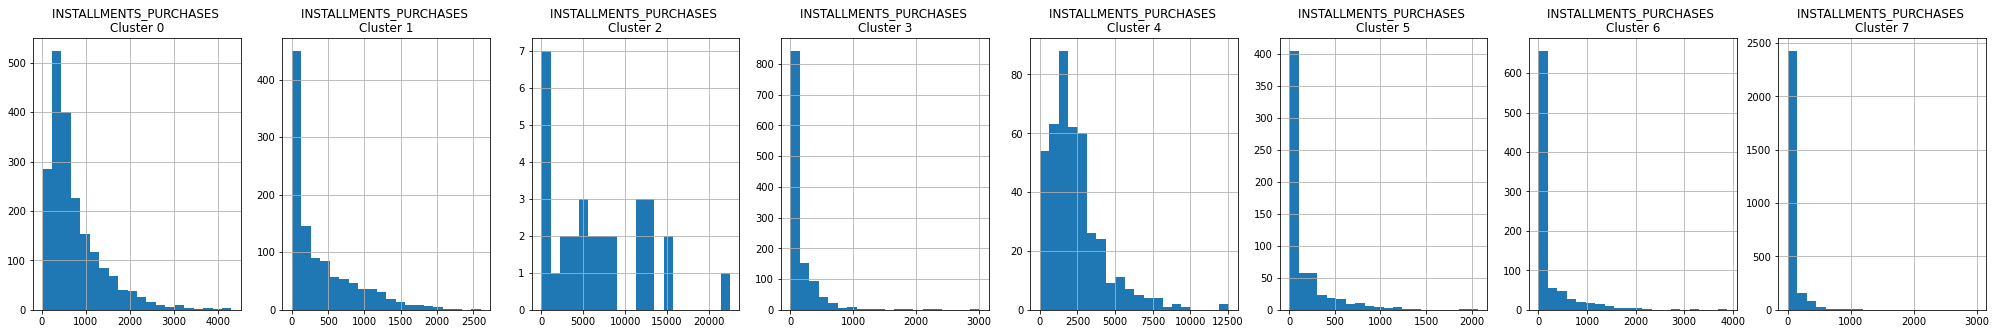

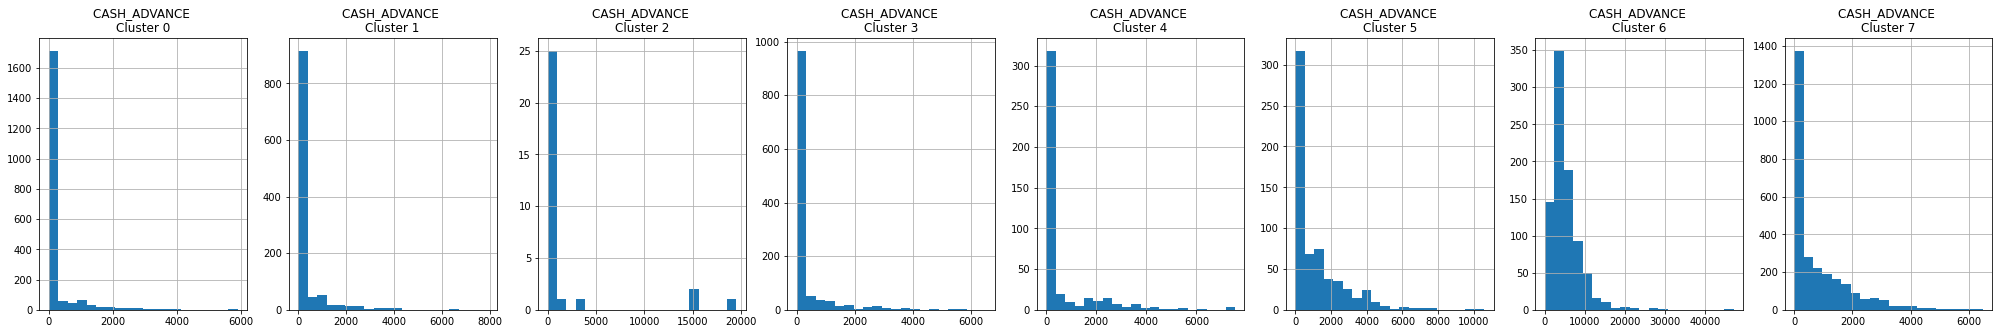

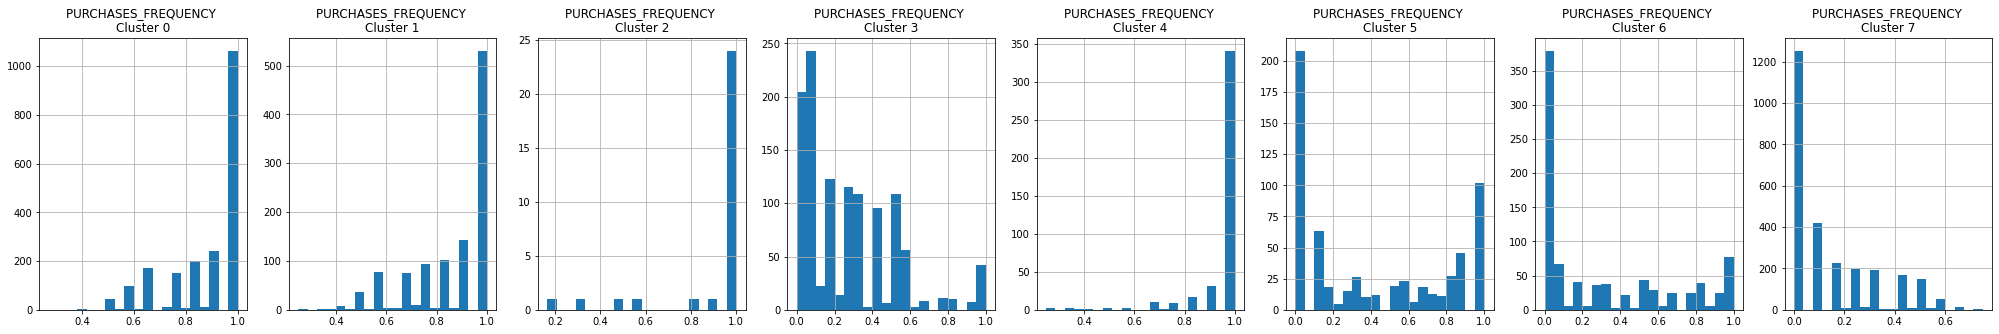

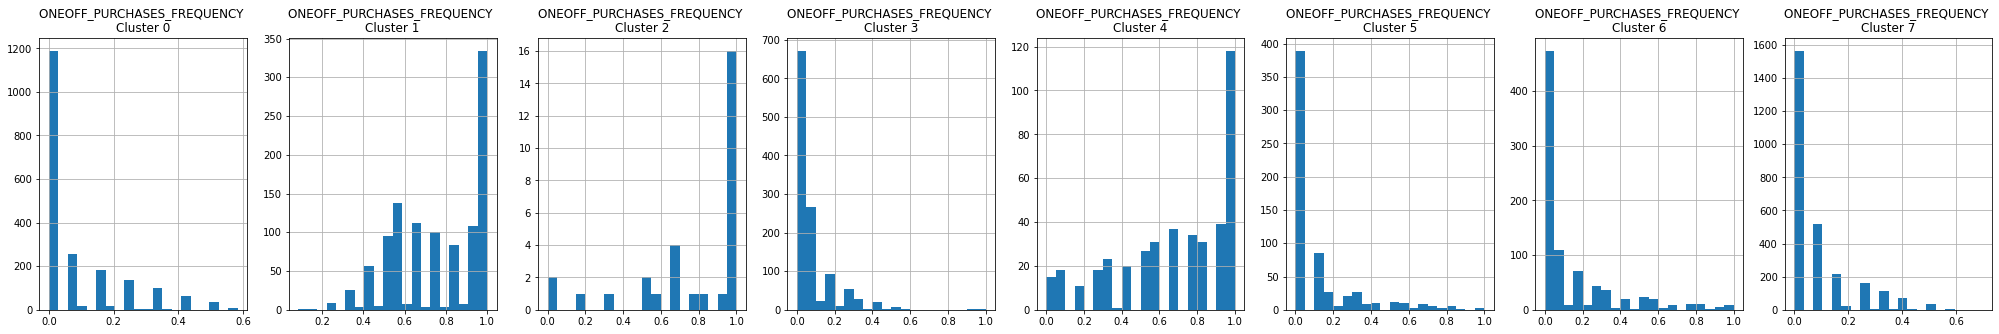

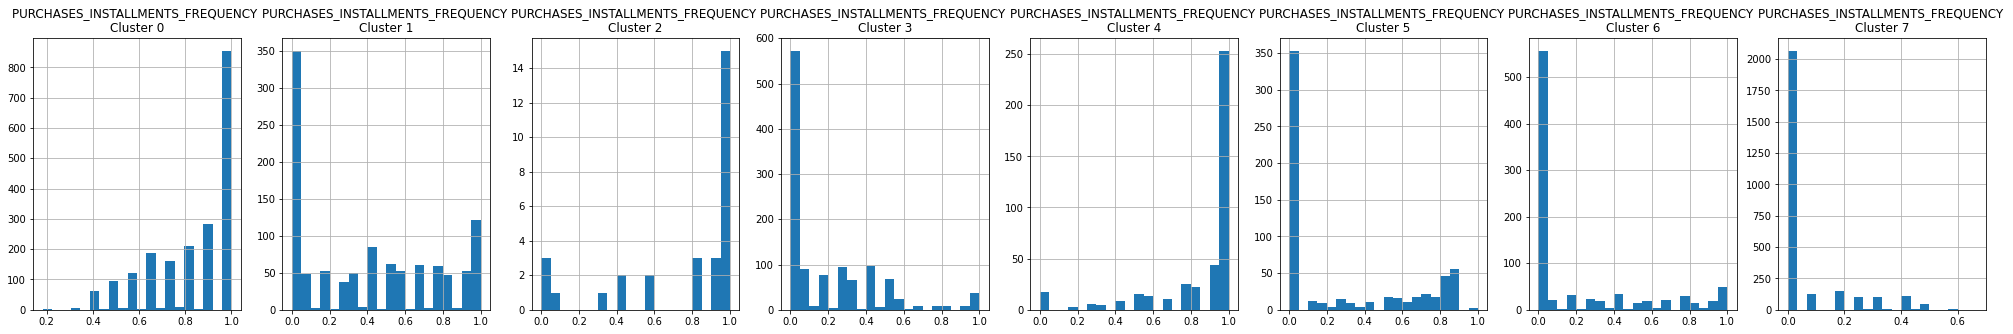

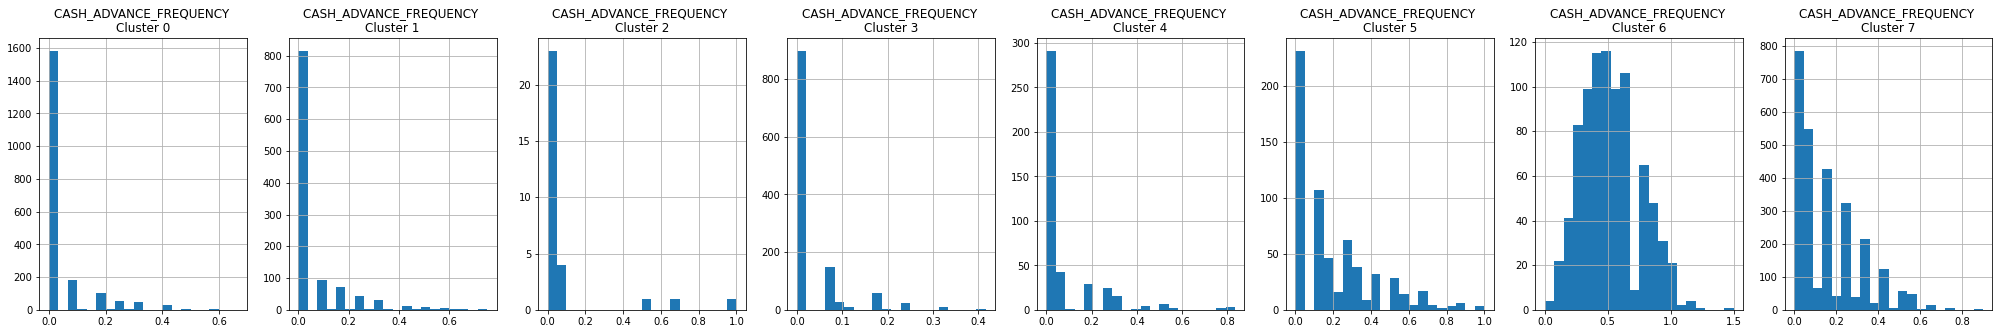

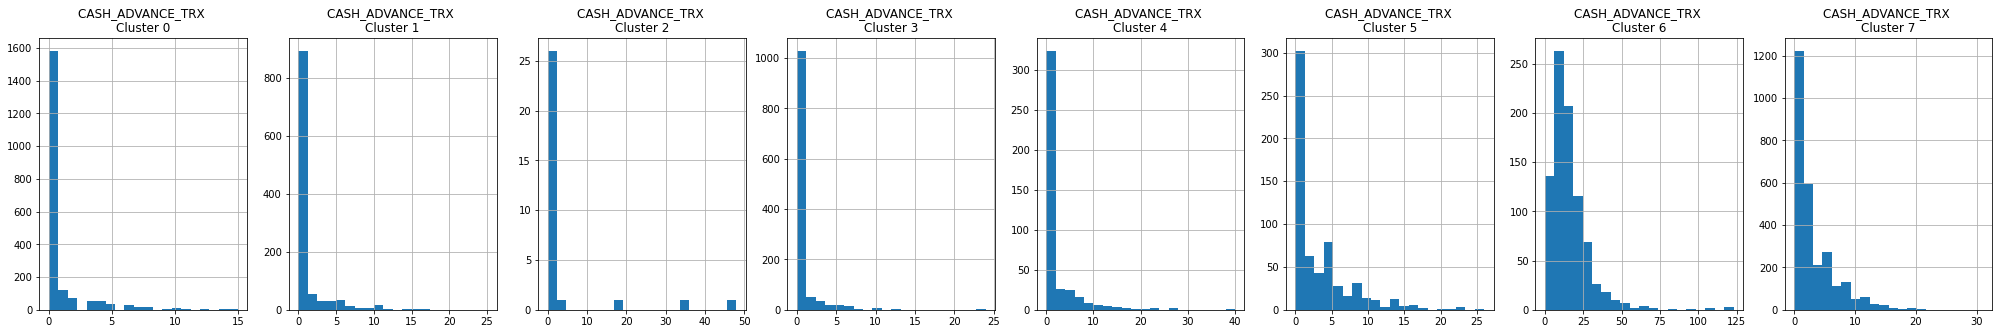

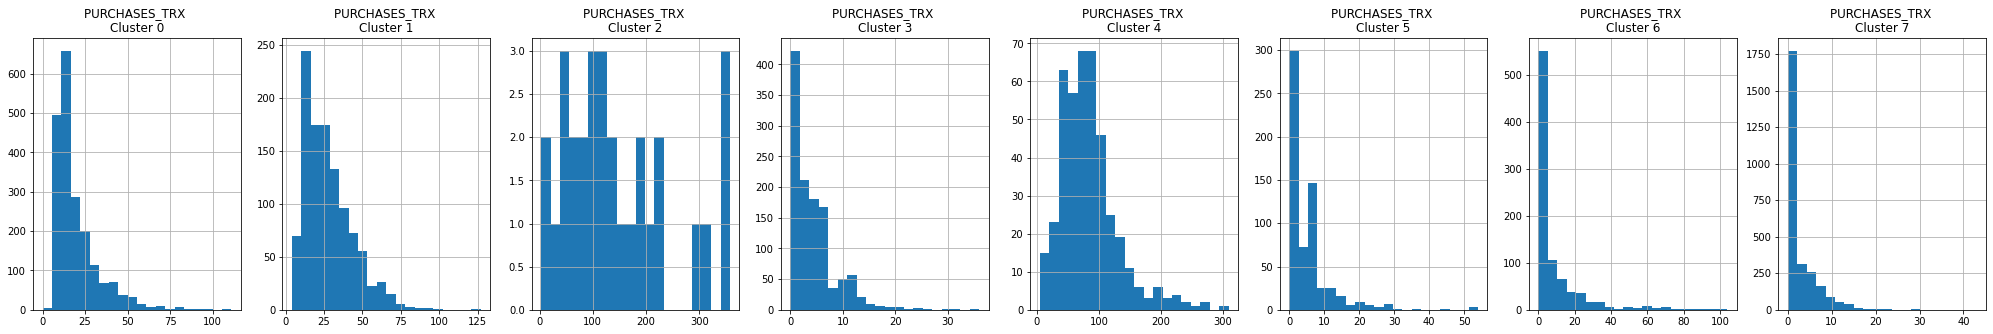

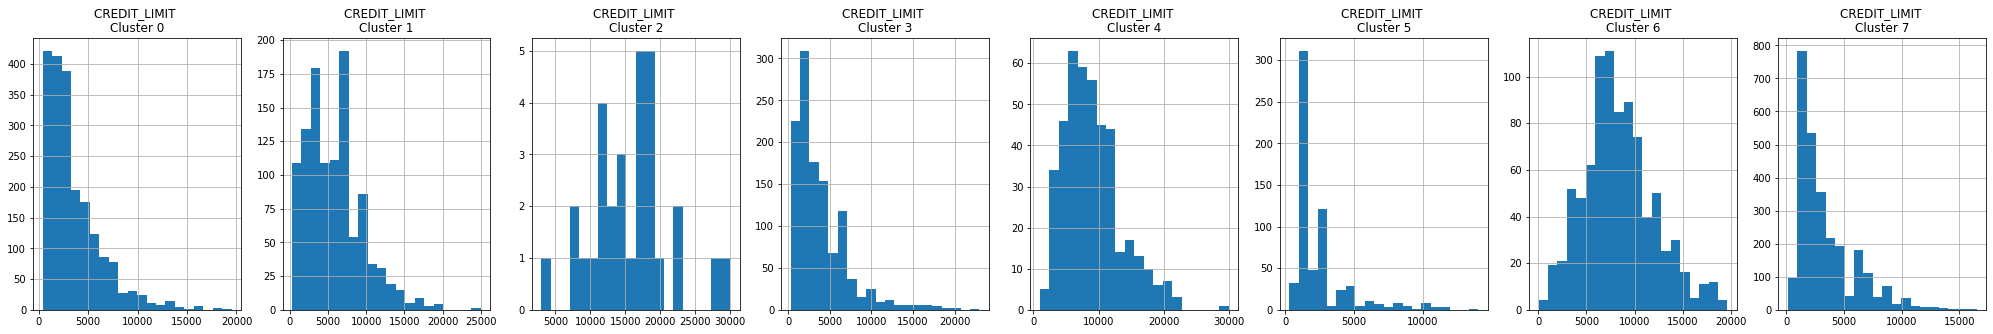

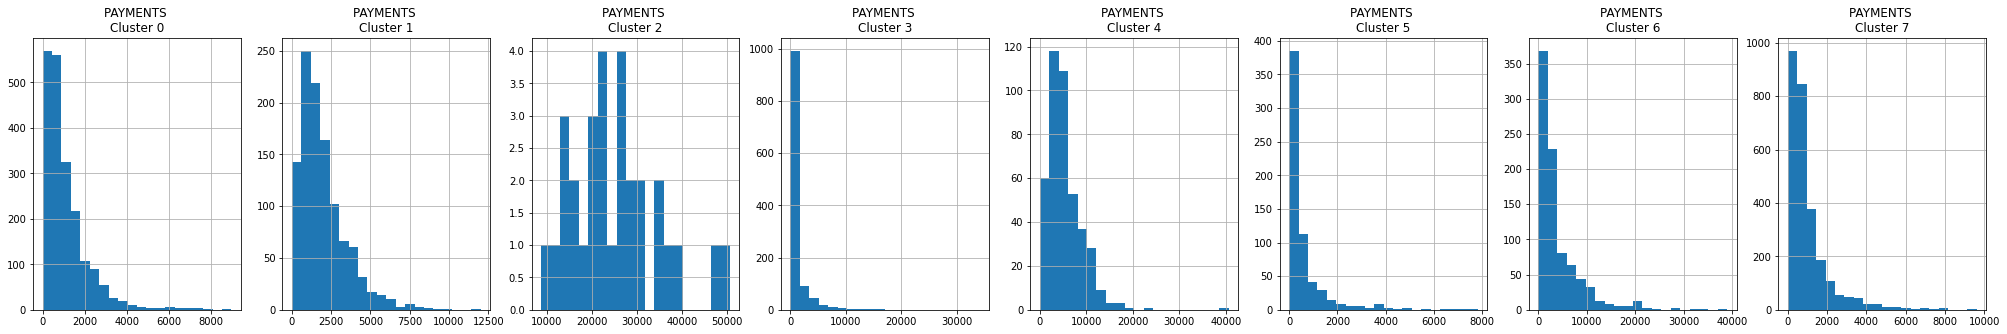

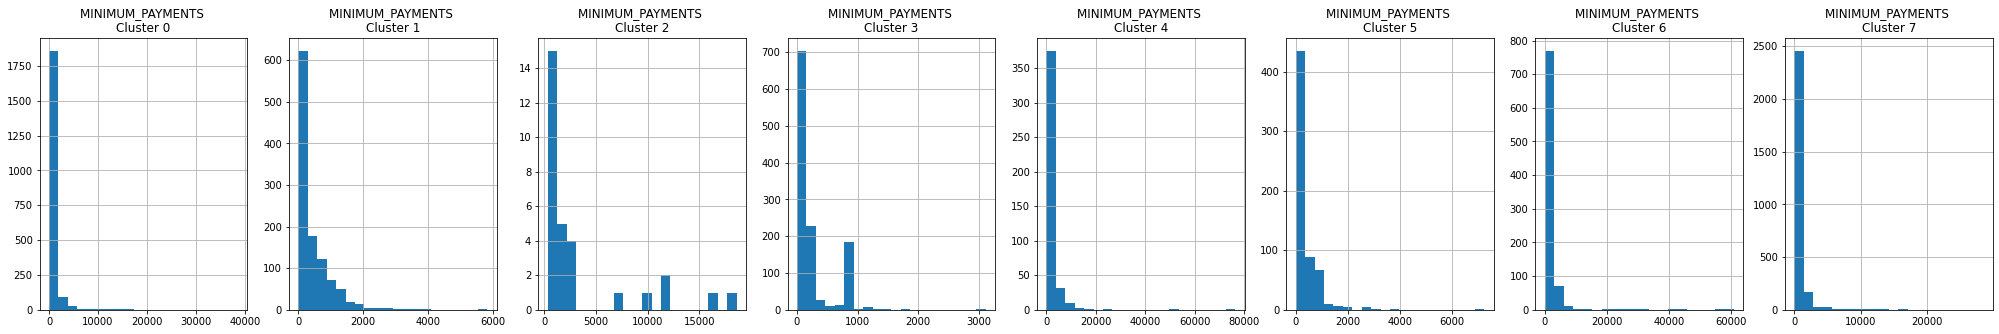

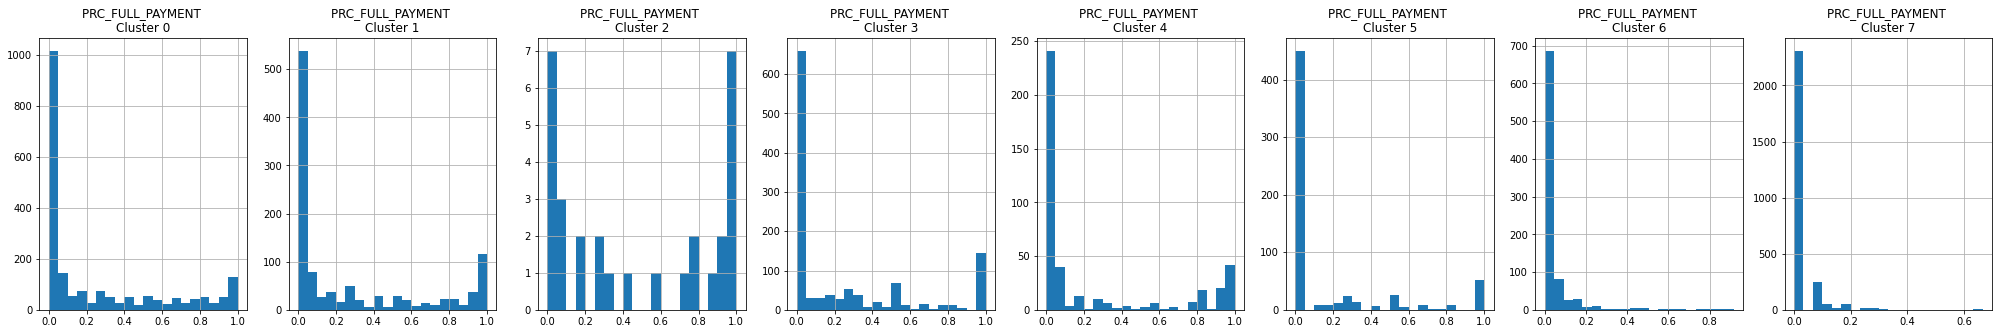

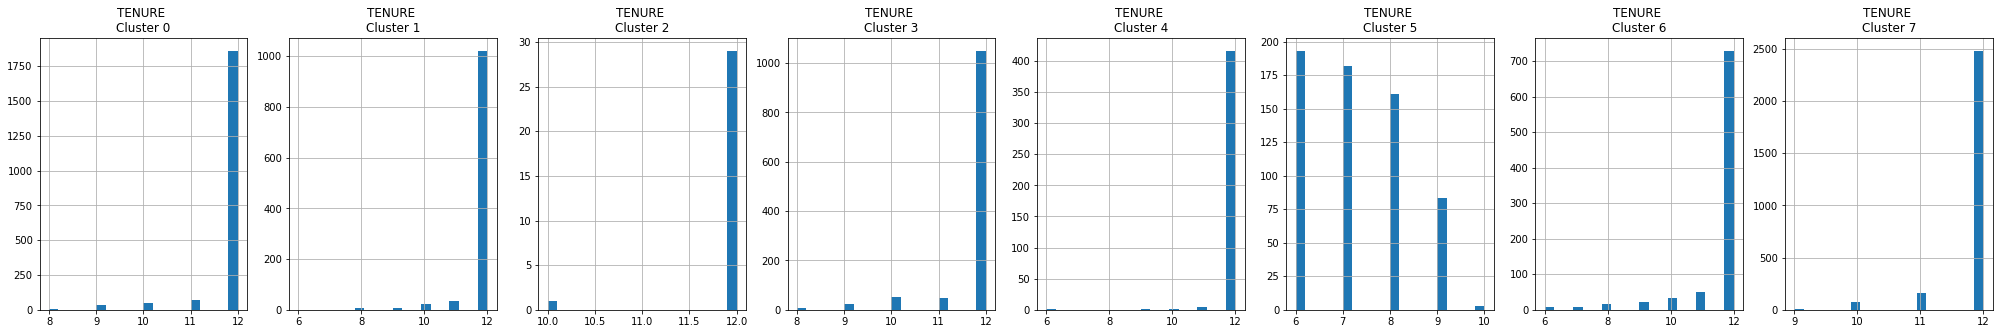

In [22]:
# Plot the histogram of various clusters

for i in data.columns:
    plt.figure(figsize=(35,5))
    for j in range(8):
        plt.subplot(1,8,j+1)
        cluster = data_cluster[data_cluster['cluster']==j]
        cluster[i].hist(bins=20)
        plt.title('{} \nCluster {}'.format(i,j))
plt.show();

### Apply Principal Component Analysis and visualize the result

In [23]:
# Obtain the principal components 

pca = PCA(n_components=2)
principal_comp = pca.fit_transform(data_scaled)
principal_comp

array([[-1.68222036, -1.07644833],
       [-1.13829333,  2.50647303],
       [ 0.96968438, -0.38353395],
       ...,
       [-0.92620455, -1.81078029],
       [-2.33655271, -0.65795567],
       [-0.55642193, -0.40047099]])

In [24]:
# Create a dataframe with two components

pca_df = pd.DataFrame(principal_comp, columns=['pca1', 'pca2'])
pca_df.head()

,pca1,pca2
0,-1.682220,-1.076448
1,-1.138293,2.506473
2,0.969684,-0.383534
3,-0.873627,0.043169
4,-1.599434,-0.688579


In [25]:
# Concatenate the clusters labels to the dataframe

pca_df = pd.concat([pca_df, pd.DataFrame({'cluster': labels})], axis=1)
pca_df.head(10)

,pca1,pca2,cluster
0,-1.682220,-1.076448,7
1,-1.138293,2.506473,6
2,0.969684,-0.383534,1
3,-0.873627,0.043169,7
4,-1.599434,-0.688579,7
5,0.251294,-0.780077,0
6,6.352920,-0.692521,4
7,0.277103,-1.290734,0
8,-0.441745,-0.461832,7
9,-0.562510,-0.366333,3


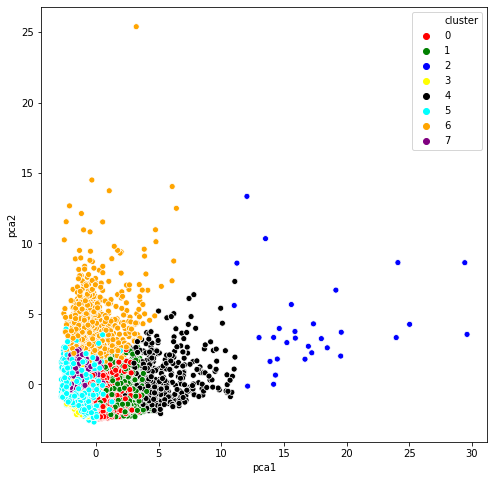

In [26]:
plt.figure(figsize=(8,8))
ax = sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=pca_df,
                     palette=['red', 'green', 'blue', 'yellow', 'black', 'cyan', 'orange', 'purple'])

### Autoencoders

Autoencoders are a type og neural networks used to perform a task of data encoding (representation learning). To do so, they use the same data as inpur and as output. Autoencoders work by adding a bootleneckbetween the first part, called <em>Encoder</em>, and the second part, called <em>Decoder</em>. This bottleneck forces the network to create a compressed version of our input. As we should know by now, this compression works well if the data are somehow correlated. For this reason, autoencoders are often used to perform <em>dimensionality reduction</em>.

In [27]:
# importing libraries

from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import SGD

In [28]:
encoding_dim = 7
input_df = Input(shape=(17,))

In [29]:
# building our autoencoder

x = Dense(encoding_dim, activation='relu')(input_df)
x = Dense(500, activation='relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(500, activation='relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation='relu', kernel_initializer = 'glorot_uniform')(x)

encoded = Dense(10, activation='relu', kernel_initializer = 'glorot_uniform')(x)

x = Dense(2000, activation='relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(500, activation='relu', kernel_initializer = 'glorot_uniform')(x)

decoded = Dense(17, kernel_initializer = 'glorot_uniform')(x)

# autoencoder
autoencoder = Model(input_df, decoded)

#encoder - used for our dimention reduction
encoder = Model(input_df, encoded)

In [30]:
# compiling and showing summary of our autoencoder

autoencoder.compile(optimizer= 'adam', loss='mean_squared_error', metrics=['accuracy'])
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 17)]              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 126       
_________________________________________________________________
dense_1 (Dense)              (None, 500)               4000      
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 2000)              1002000   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                20010     
_________________________________________________________________
dense_5 (Dense)              (None, 2000)              22000 

In [31]:
# training network

autoencoder.fit(data_scaled, data_scaled, batch_size = 128, epochs = 25,  verbose = 1)

Epoch 1/25
70/70 [==============================] - 2s 24ms/step - loss: 0.5480 - accuracy: 0.2517
Epoch 2/25
70/70 [==============================] - 2s 27ms/step - loss: 0.3167 - accuracy: 0.4806
Epoch 3/25
70/70 [==============================] - 2s 27ms/step - loss: 0.2298 - accuracy: 0.5673
Epoch 4/25
70/70 [==============================] - 2s 26ms/step - loss: 0.1868 - accuracy: 0.6101
Epoch 5/25
70/70 [==============================] - 2s 27ms/step - loss: 0.1586 - accuracy: 0.6451
Epoch 6/25
70/70 [==============================] - 2s 25ms/step - loss: 0.1450 - accuracy: 0.6762
Epoch 7/25
70/70 [==============================] - 2s 26ms/step - loss: 0.1343 - accuracy: 0.6946
Epoch 8/25
70/70 [==============================] - 2s 25ms/step - loss: 0.1191 - accuracy: 0.7115
Epoch 9/25
70/70 [==============================] - 2s 24ms/step - loss: 0.1213 - accuracy: 0.7108
Epoch 10/25
70/70 [==============================] - 2s 24ms/step - loss: 0.1100 - accuracy: 0.7275
Epoch 11/

In [32]:
# saving model

autoencoder.save_weights('autoencoder.h5')

In [33]:
# Now we will use just the Encoder part to reduce the dimesionality of our data from 17 to 10

pred = encoder.predict(data_scaled)
pred.shape

(8950, 10)

/Users/maurizioscibilia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  # This is added back by InteractiveShellApp.init_path()
/Users/maurizioscibilia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  del sys.path[0]


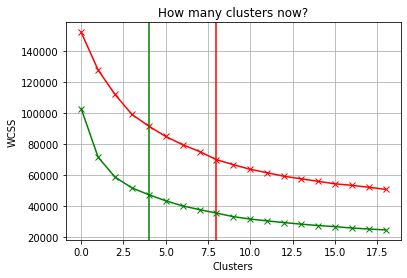

In [34]:
# first, we find the best number of clusters using the ELBOW methow, like we did previously
# this time though, we show both the scores in the same chart to compare them

scores_ae = []
range_values = range(1,20)
for i in range_values:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(pred)
    scores_ae.append(kmeans.inertia_)
 
plt.plot(scores, 'bx-', color='r')
plt.axvline(x=8, color='r')
plt.plot(scores_ae, 'bx-', color='g')
plt.axvline(x=4, color='g')
plt.title('How many clusters now?')
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show();

# the elbow seems around 4 now

In [35]:
# applying k-means to our new data

kmeans = KMeans(4)
kmeans.fit(pred)
labels = kmeans.labels_

In [36]:
# as before, we concatenate these labels to our dataframe, but now we have a half of the clusters

data_cluster_ae = pd.concat([data, pd.DataFrame({'cluster': labels})], axis=1)
data_cluster_ae.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,1
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,1
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,1
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,1


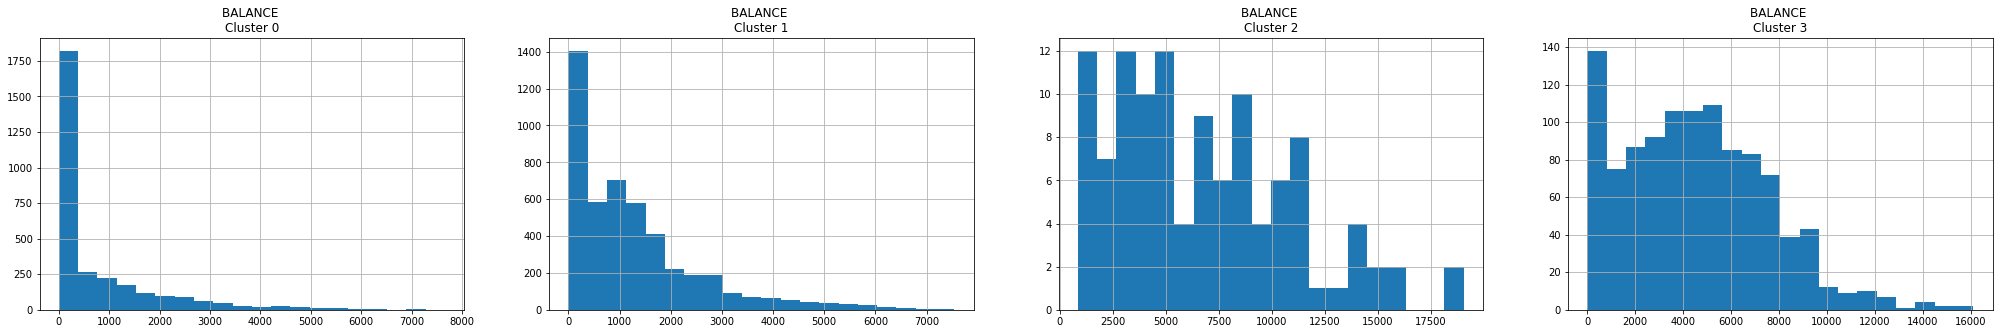

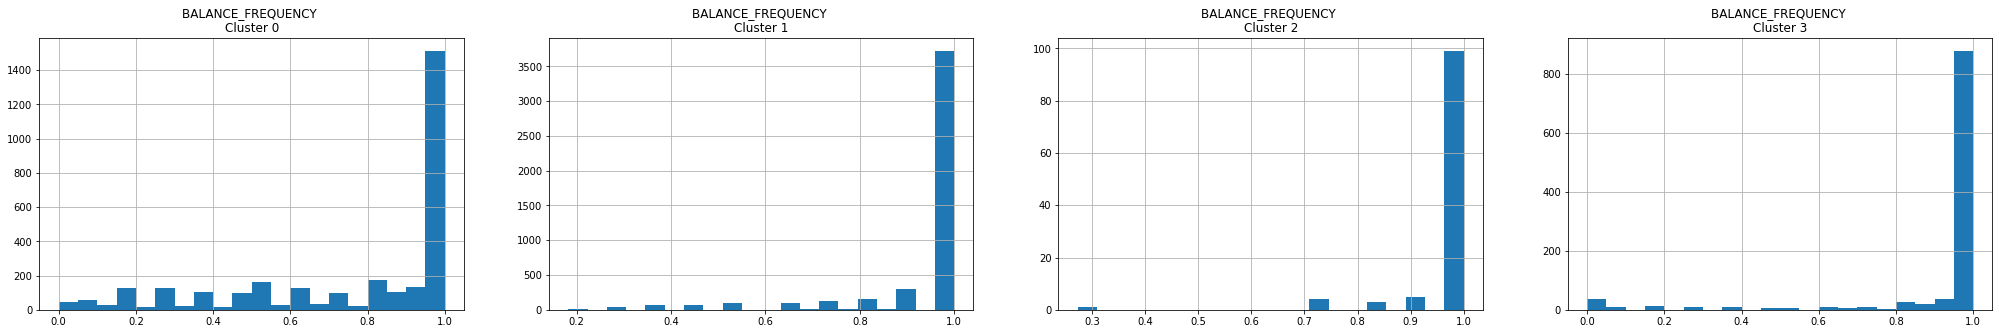

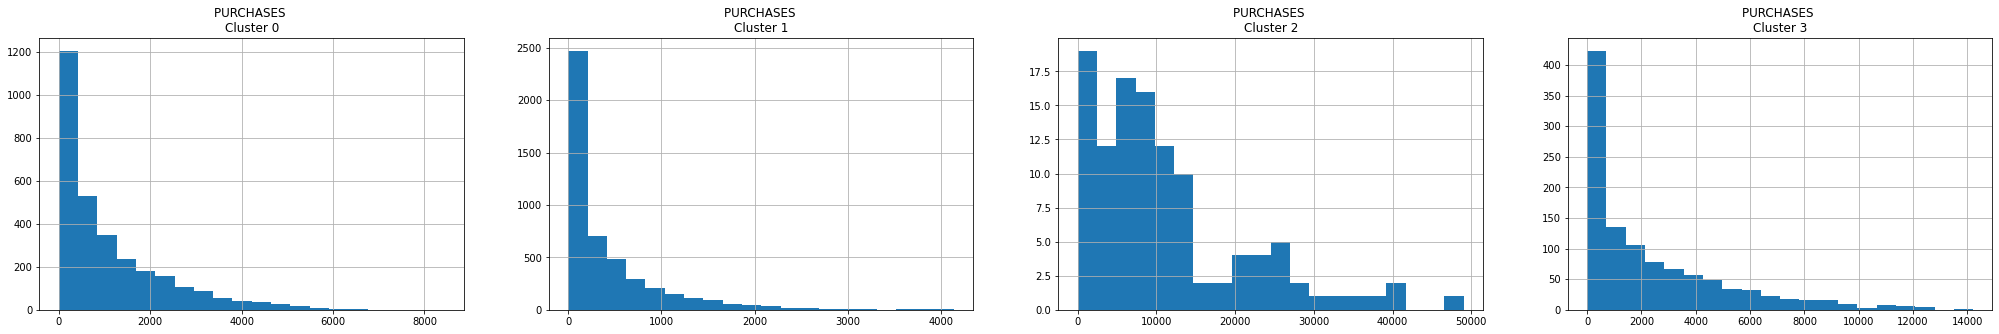

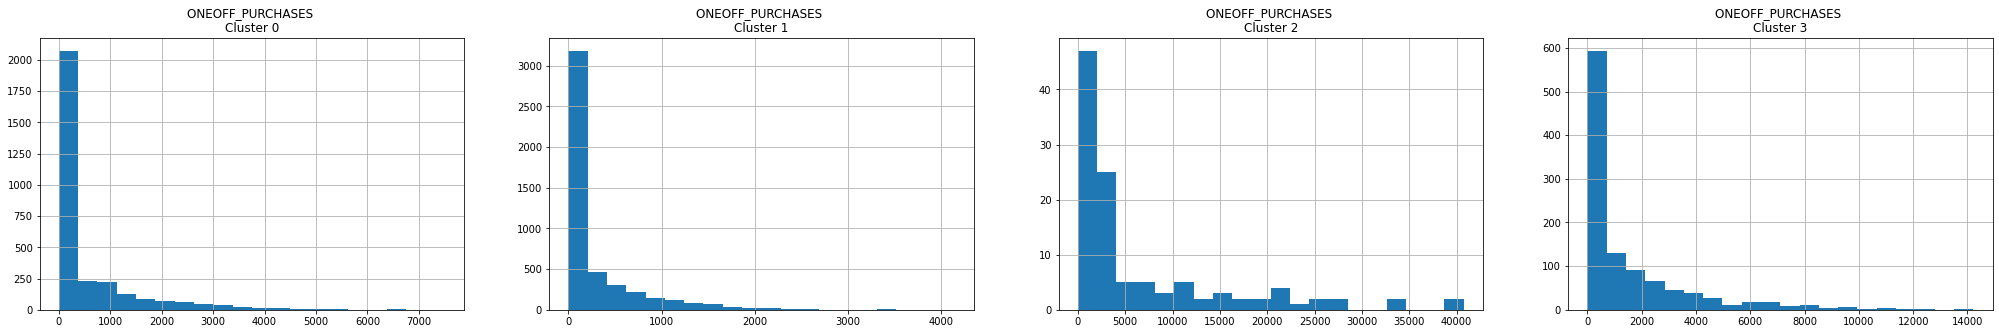

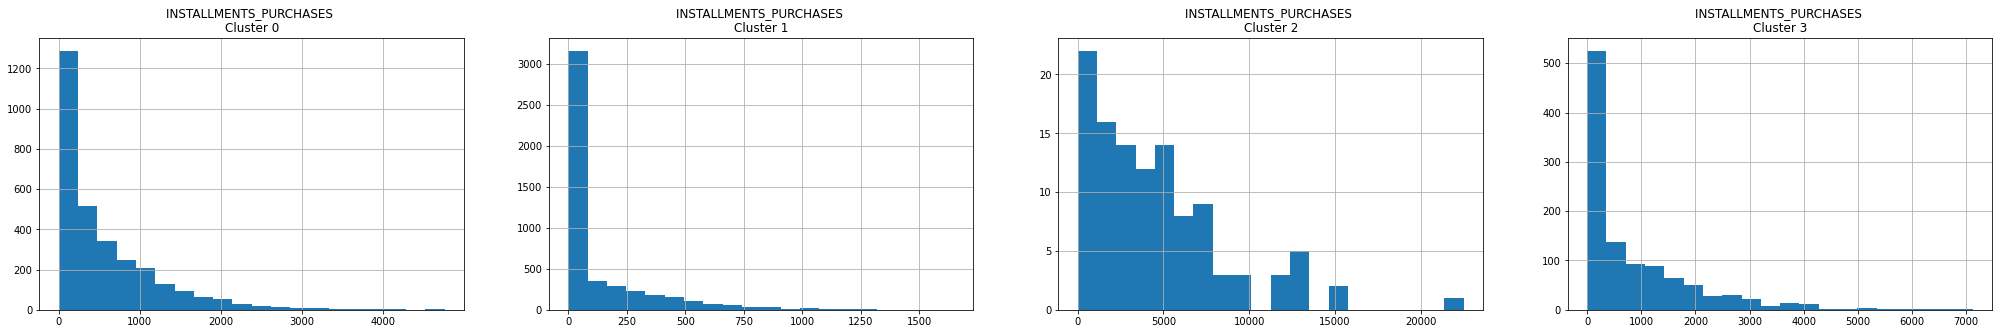

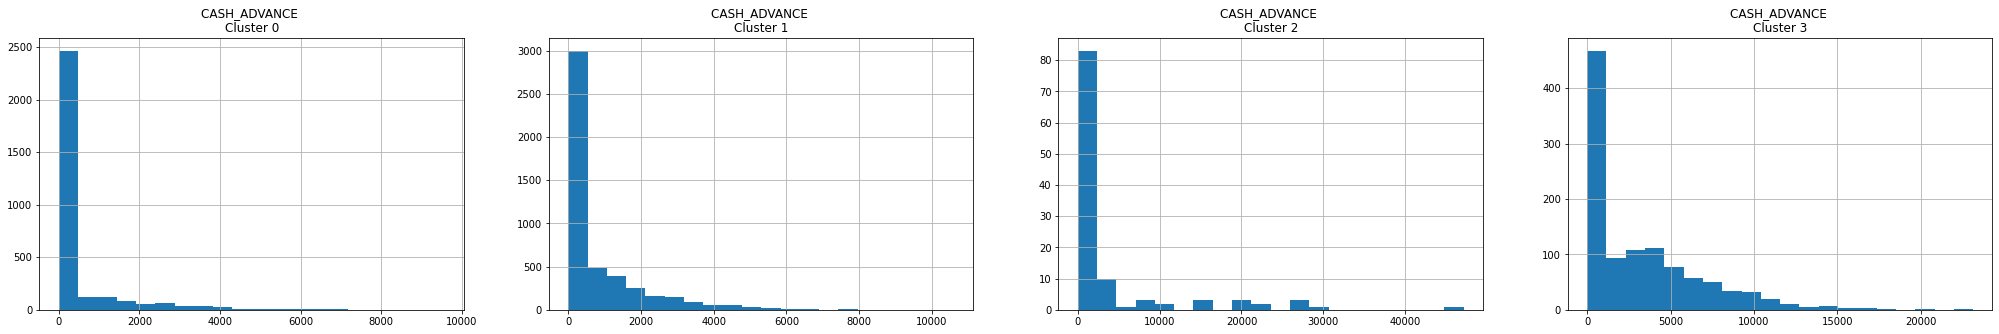

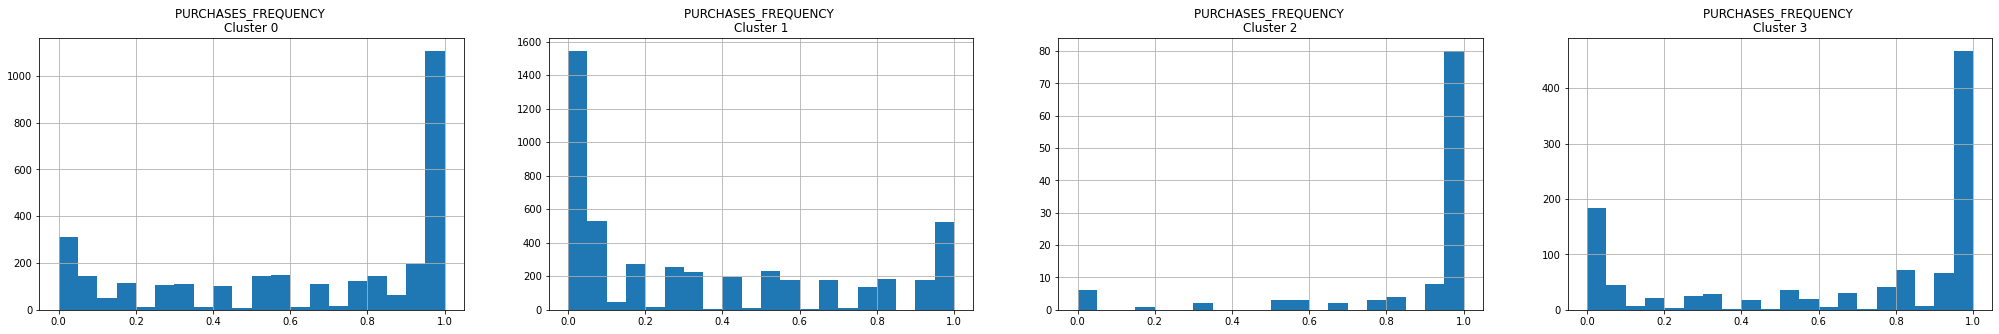

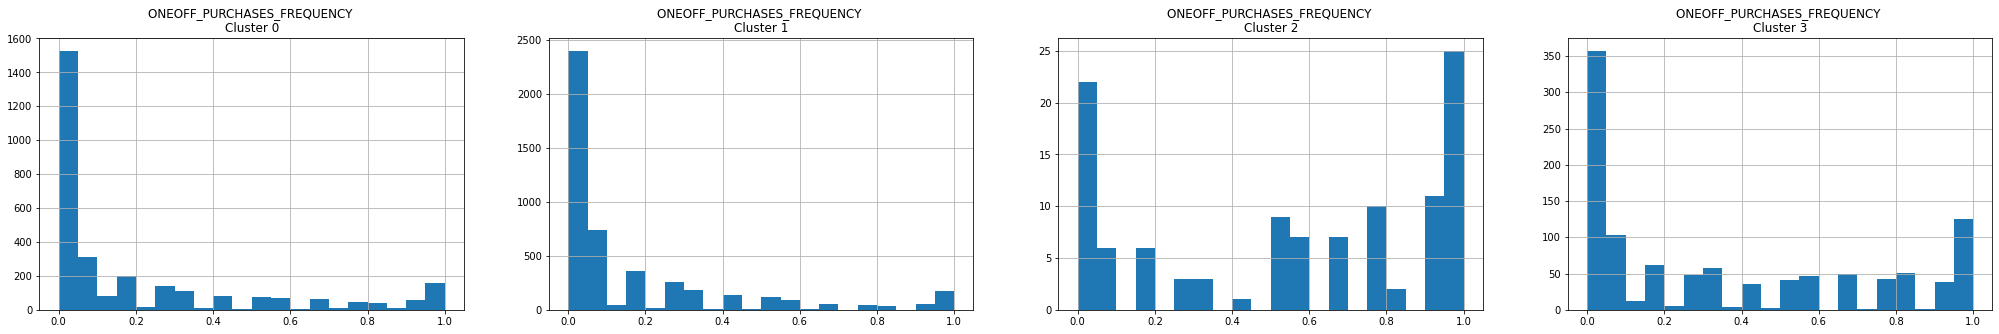

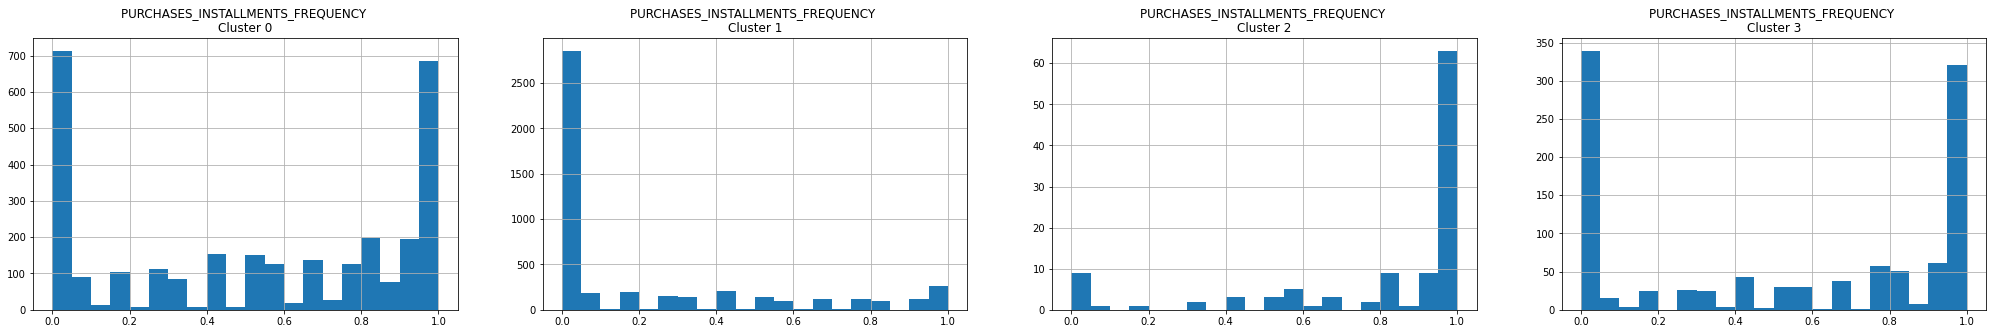

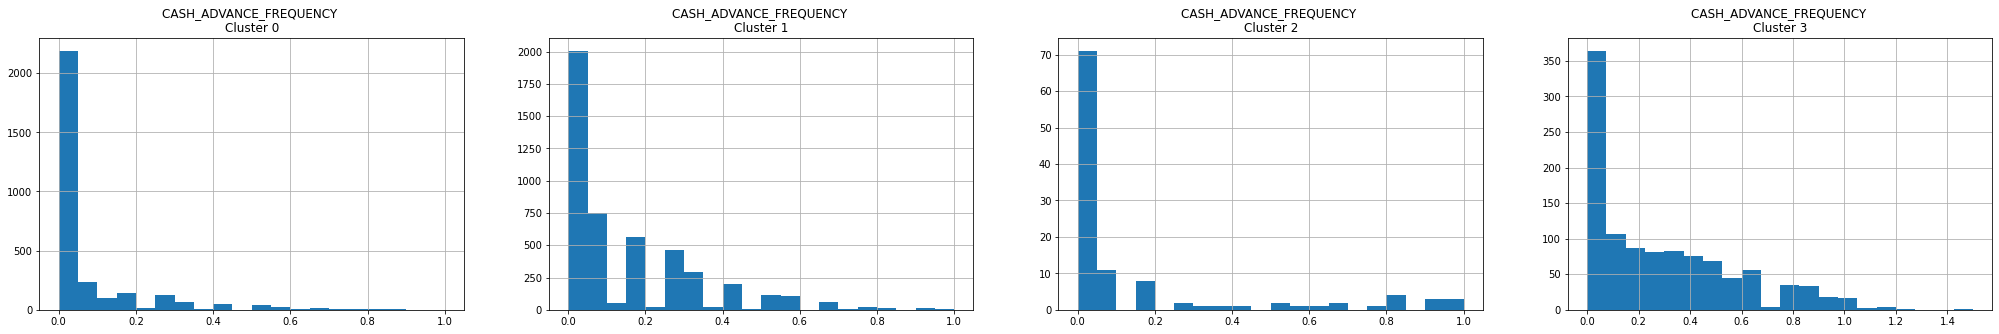

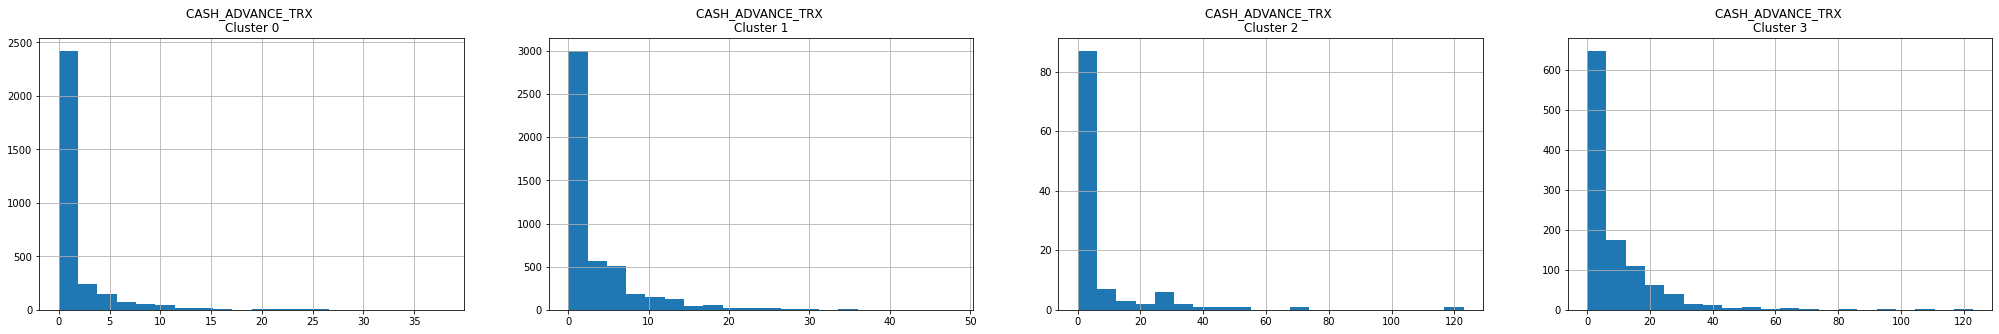

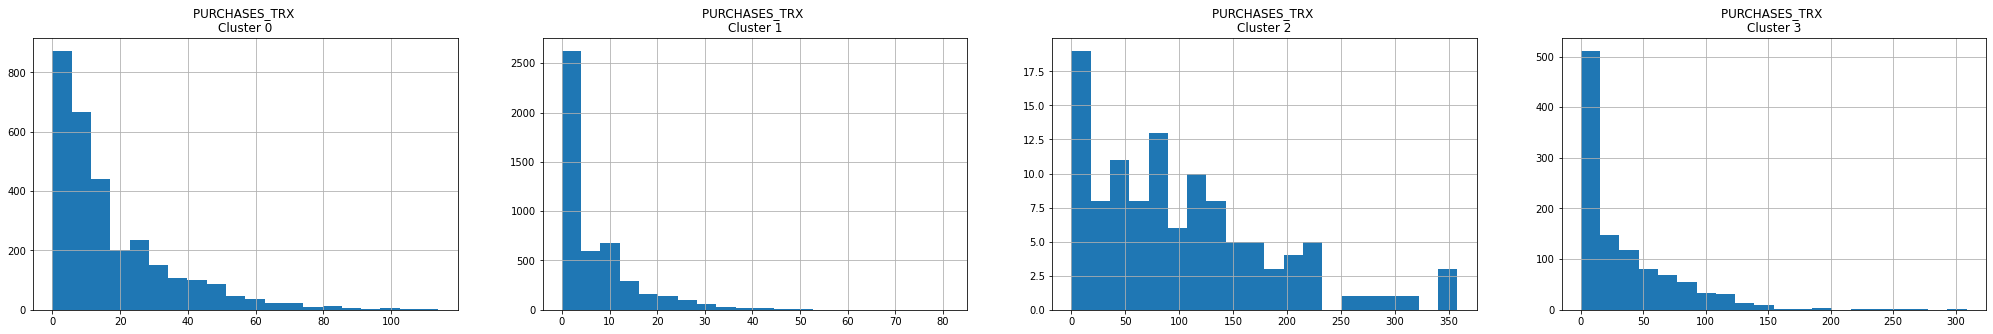

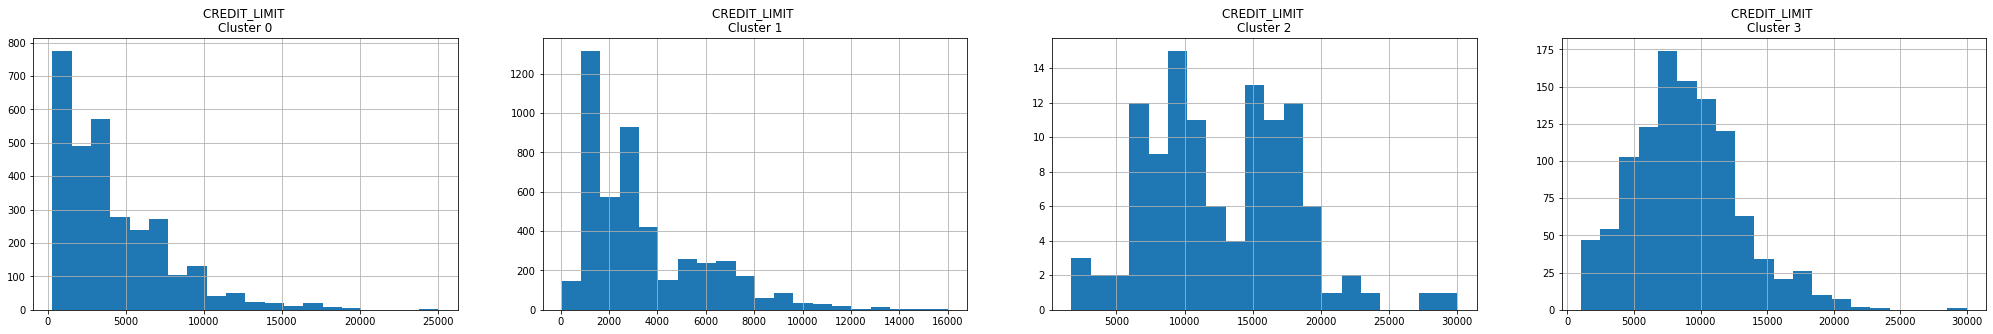

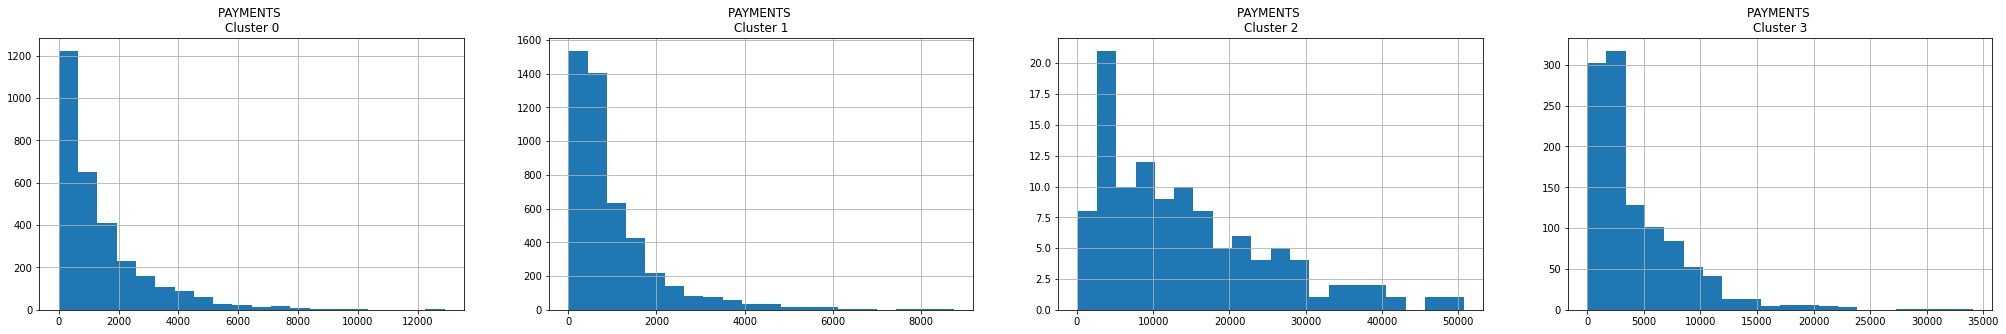

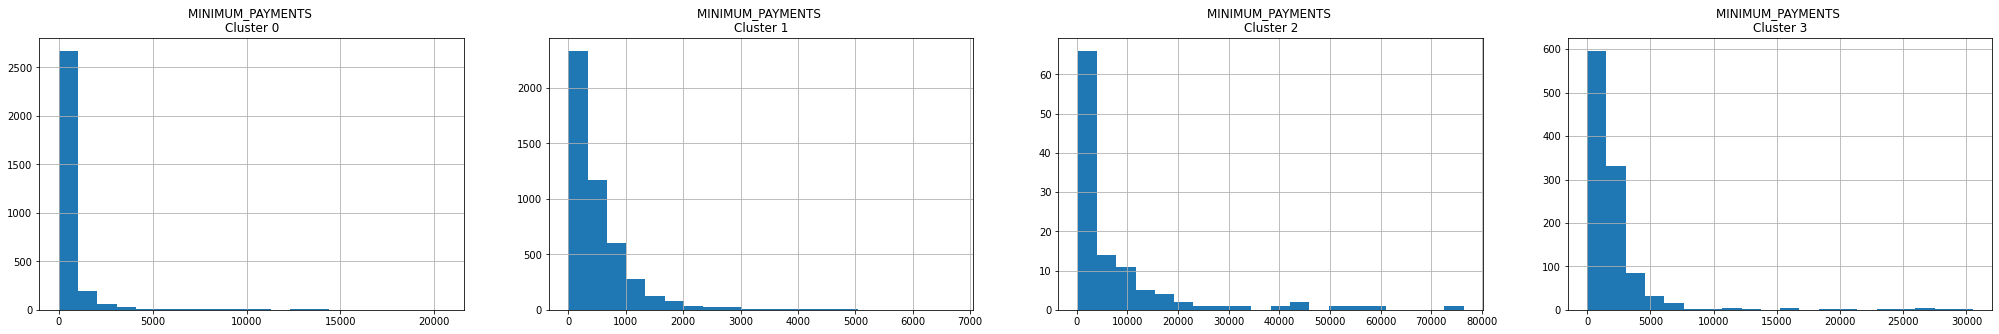

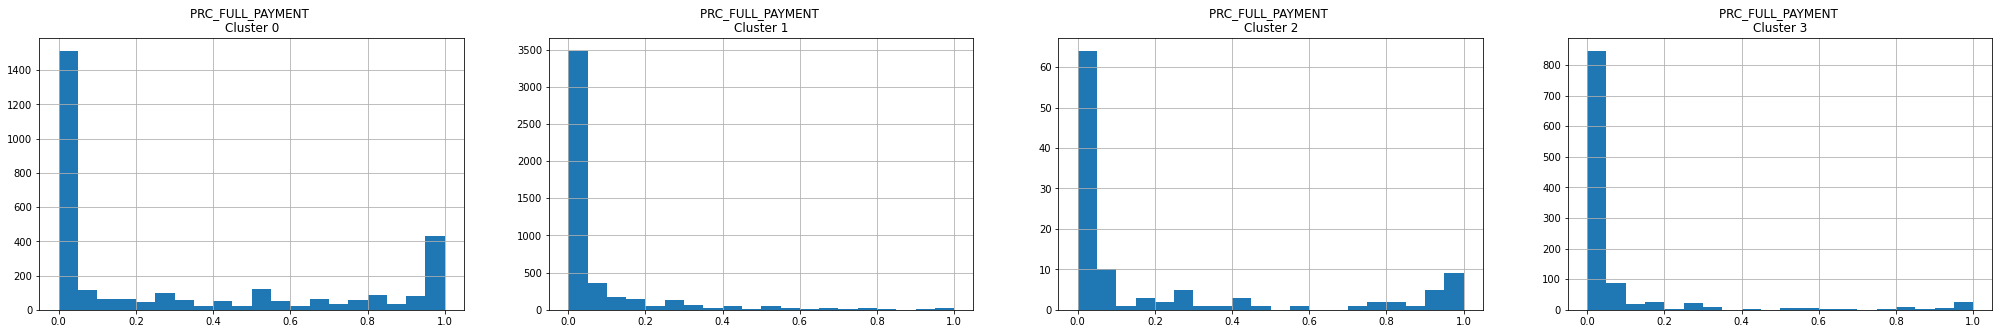

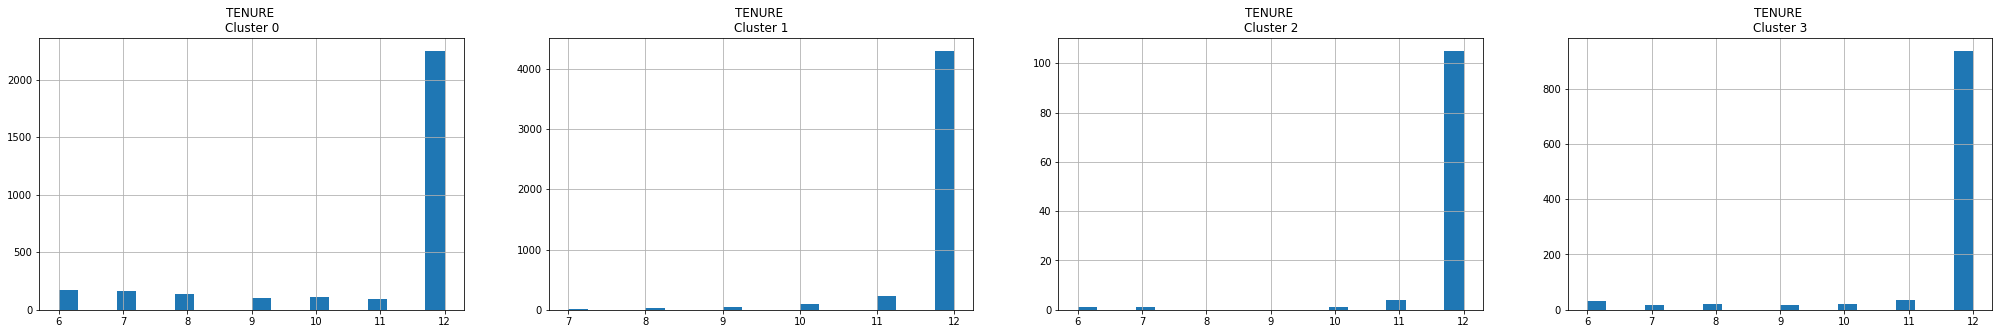

In [37]:
# Plot the histogram of various clusters - remember that now they are only 4

for i in data.columns:
    plt.figure(figsize=(35,5))
    for j in range(4):
        plt.subplot(1,4,j+1)
        cluster = data_cluster_ae[data_cluster_ae['cluster']==j]
        cluster[i].hist(bins=20)
        plt.title('{} \nCluster {}'.format(i,j))
plt.show();

In [38]:
# now, we apply pca to this data, then we add the new labels and take a look

pca_ae = PCA(n_components=2)
principal_comp_ae = pca_ae.fit_transform(pred)
pca_df_ae = pd.DataFrame(data = principal_comp_ae, columns =['pca1','pca2'])
pca_df_ae = pd.concat([pca_df_ae,pd.DataFrame({'cluster':labels})], axis = 1)
pca_df_ae.head()

,pca1,pca2,cluster
0,-2.404400,-0.049819,1
1,0.399293,1.837995,0
2,-0.002451,0.117911,1
3,-0.845818,0.101880,1
4,-2.576023,-0.075750,1


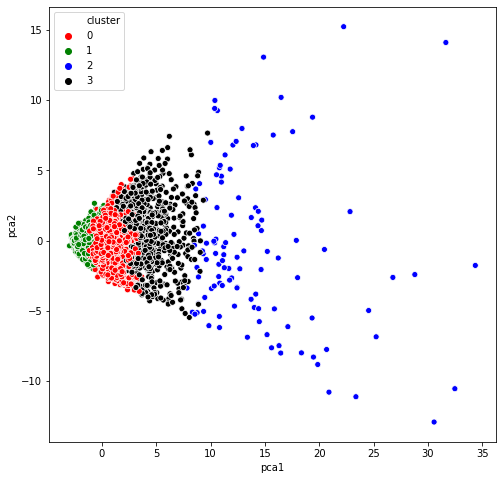

In [39]:
plt.figure(figsize=(8,8))
ax = sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=pca_df_ae,
                     palette=['red', 'green', 'blue', 'black'])

As we can see, clusters look way more separable now, in the Cartesian space. Autoencoders helped us apparently.

## Conclusions

We have seen interesting approaches for the marketing segmentation problem. Many thanks to Dr. Ryan Ahmed Ph.D. MBA for showing it inside his course on the Udemy platform. 